# signac Projectile Demo (Brief)

*The following cell resets all data from previous runs of this notebook.*

In [1]:
!rm -rf workspace signac.rc project.py dashboard.py *.err.* *.out.* signac_project_document.json view

## Introduction

This notebook gives an example of how the ``signac`` framework can be used to manage a data space and automate operations on this data space.

In this example, let's imagine that we're studying the behavior of a projectile launched at a specific velocity and angle to visualize the distance it will travel before it lands.
We use simple Newtonian mechanics to model the motion to determine how long the object travels: 

$$y(t) = y(0) + v\sin(\theta) t - \frac{1}{2} g t^2$$

Setting $y(0)=0$ and solving for $t_{max}$ such that $y(t_{max}) = 0$ yields: $t_\max= \frac{2v \sin(\theta)}{g}$

## Initial experiments

We express the simple math from above in two Python functions that calculate the maximum time the projectile travels, $t_\max$, and the $(x, y)$ coordinates of its trajectory.

In [2]:
import numpy as np

def get_t_max(v, theta, g=9.81):
    return 2 * v * np.sin(theta) / g

def compute_xy(t, v, theta, g=9.81):
    return v * np.cos(theta) * t, v * np.sin(theta) * t - (g/2) * t**2

Let's observe the effect of launching the projectile at different angles:

In [3]:
theta = 20 * np.pi / 180   # rad

t_max = get_t_max(
    v     = 2000,  # m/s
    theta = theta,
)

print("Time traveled (theta={:2.1f}): {:.2f} min".format(theta * 180/np.pi, t_max / 60))

Time traveled (theta=20.0): 2.32 min


We can also execute a slightly more "*systematic*" study of the maximum distance traveled over different launch angles:

In [4]:
for theta in np.arange(0.0, np.pi/2, 0.2):
    t_max = get_t_max(2000, theta)
    x_max = compute_xy(t_max, 2000, theta)[0]
    print("Distance traveled (theta={:04.1f}): {:3.2f} km".format(theta * 180/np.pi, x_max / 1000))

Distance traveled (theta=00.0): 0.00 km
Distance traveled (theta=11.5): 158.78 km
Distance traveled (theta=22.9): 292.50 km
Distance traveled (theta=34.4): 380.04 km
Distance traveled (theta=45.8): 407.57 km
Distance traveled (theta=57.3): 370.76 km
Distance traveled (theta=68.8): 275.42 km
Distance traveled (theta=80.2): 136.59 km


We have a plotting function in the `render.py` module:

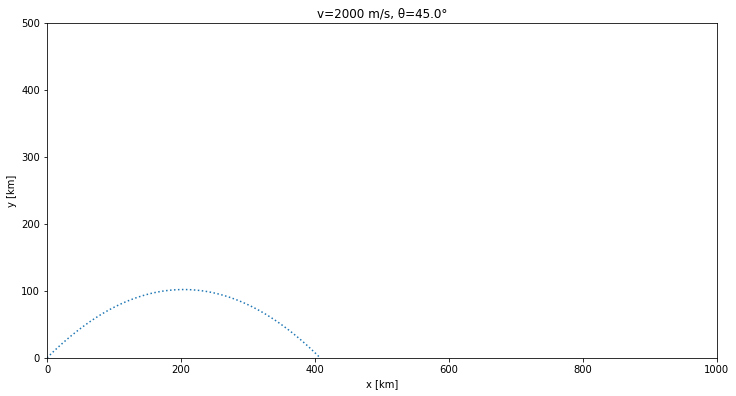

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from render import plot

fig, ax = plot(velocity=2000, theta=45 * np.pi / 180)
plt.show()

## Initialize a data space

So far so good, but now, let's see how we can manage this data with ``signac``. 

In [6]:
import signac

# Start by initializing a project
project = signac.init_project("Projectile-Project")

# Obtain a 'job' handle for a specific *state point*:
job = project.open_job({"theta": 0.4, "velocity": 2000})

In [7]:
# JSON-encodable data can be stored in the *job document*, which works like a persistent dict:
job.doc['t_max'] = get_t_max(v=job.sp['velocity'], theta=job.sp['theta'])

# Just like the state point, the document data can also be accessed via *attributes*:
job.doc.x_max = compute_xy(t=job.doc.t_max, v=job.sp.velocity, theta=job.sp.theta)[0]

In [8]:
print(job.sp)
print(job.doc)

{'theta': 0.4, 'velocity': 2000}
{'t_max': 158.78423743471987, 'x_max': 292499.9351272264}


A *job* essentially represents a directory within our *workspace* on the file system.

In [9]:
print(job.get_id())
print(job.workspace())

d1e4f4e909ca09c26abfe0c0875bff3f
/home/bdice/code/signac-micde-cnsccs-2018/projectile/workspace/d1e4f4e909ca09c26abfe0c0875bff3f


We can use that to manage files directory on the file system:

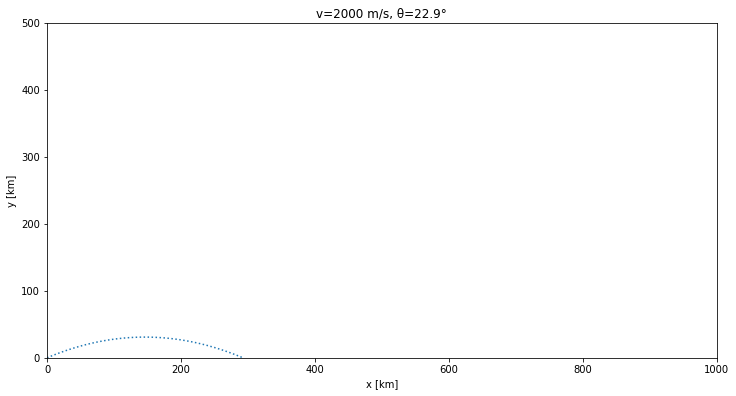

In [10]:
fig, ax = plot(velocity=job.sp.velocity, theta=job.sp.theta)

fig.savefig(job.fn('trajectory.png'))

The `job.fn('trajectory.png')` command is a short-cut for `os.path.join(job.workspace(), 'trajectory.png')`.

We have now created the following directory structure on the file system:

In [11]:
! find . -not -path '*/[\._]*'

.
./render.py
./signac-projectile-demo-brief-rendered.ipynb
./signac-projectile-demo-brief.ipynb
./signac-projectile-demo-full.ipynb
./signac.rc
./workspace
./workspace/d1e4f4e909ca09c26abfe0c0875bff3f
./workspace/d1e4f4e909ca09c26abfe0c0875bff3f/signac_job_document.json
./workspace/d1e4f4e909ca09c26abfe0c0875bff3f/signac_statepoint.json
./workspace/d1e4f4e909ca09c26abfe0c0875bff3f/trajectory.png


## Expand data space

We've shown how this works for one data point.

However, `signac` is designed to interact with large data spaces with lots of data points.
This is useful, for example to conduct a parameter study of various launch angles:

In [12]:
for velocity in 2000, 2500, 3000:
    for theta in 0.4, 0.625, 0.85, 1.3:
        job = project.open_job({"velocity": velocity, "theta": theta})
        job.doc.t_max = get_t_max(v=job.sp.velocity, theta=job.sp.theta)
        job.doc.x_max = compute_xy(t=job.doc.t_max, v=job.sp.velocity, theta=job.sp.theta)[0]

## Accessing this data

The data is stored persistently on the file system and can be accessed later, for example, by iterating over the entire project.

In [13]:
x_max = 0
theta_max = 0

for job in project:
    if job.doc.x_max > x_max:
        x_max = job.doc.x_max
        theta_max = job.sp.theta

print("The furthest distance traveled was {:3.2f} km with \u03b8={:04.1f}\u00b0.".format(
    x_max/1000, theta_max*180/np.pi))

The furthest distance traveled was 909.78 km with θ=48.7°.


## Defining workflows with signac-flow

Since we're now working with a larger data space, it is a good idea to automate our workflow.
For this we define a `FlowProject` and functions that *operate* on the data space as part of a workflow.
We define `MyProject` as a class that inherits its behavior directly from the `FlowProject`.

In [14]:
%%writefile project.py
from flow import FlowProject
import numpy as np


def get_t_max(v, theta, g=9.81):
    return 2 * v * np.sin(theta) / g


def compute_xy(t, v, theta, g=9.81):
    return v * np.cos(theta) * t, v * np.sin(theta) * t - (g/2) * t**2


from flow import FlowProject

class MyProject(FlowProject):
    pass


@MyProject.label
def trajectory_computed(job):
    return job.isfile('trajectory.npz')


@MyProject.operation
@MyProject.post(trajectory_computed)
def compute_trajectory(job):
    from time import sleep; sleep(1)  # add some artificial computational cost here
    t = np.linspace(0, get_t_max(job.sp.velocity, job.sp.theta), 100)
    xy = np.asarray(compute_xy(t, job.sp.velocity, job.sp.theta)).T
    np.savez(job.fn('trajectory.npz'), t=t, xy=xy)
    
    job.doc.t_max = t.max()
    job.doc.x_max = xy[:, 0].max()


@MyProject.operation
@MyProject.pre.after(compute_trajectory)
@MyProject.post.isfile('trajectory.png')
def plot_trajectory(job):
    from render import plot
    fig, ax = plot(velocity=job.sp.velocity, theta=job.sp.theta)
    fig.savefig(job.fn('trajectory.png'))


if __name__ == '__main__':
    MyProject().main()

Writing project.py


In [15]:
!python3 project.py status --full --pretty --parameters velocity theta --stack

Collect job status info: 100%|█████████████████| 12/12 [00:00<00:00, 581.94it/s]
# Overview:
Total # of jobs: 12

label    ratio
-------  -------
[no labels to show]

# Detailed View:
job_id                              velocity    theta  labels
--------------------------------  ----------  -------  --------
169d4548f467018d52dd1ed7cb4a116c        3000    0.625
├● compute_trajectory [U]
└○ plot_trajectory    [U]
32fc6fc04439737373a7b22b53a8c940        2500    0.625
├● compute_trajectory [U]
└○ plot_trajectory    [U]
3370bc0aa98a61b99e21893798c582b8        2000    0.625
├● compute_trajectory [U]
└○ plot_trajectory    [U]
409bd7c78ce407c20234029f01132657        2000    0.85
├● compute_trajectory [U]
└○ plot_trajectory    [U]
4504d52a91ce8e0cf8ef3884aa0a03df        2500    0.4
├● compute_trajectory [U]
└○ plot_trajectory    [U]
5bacf98e0e5445844ca19aeccfd6c541        3000    1.3
├● compute_trajectory [U]
└○ plot_trajectory    [U]
5dd37c0c77d5dde1f69e07a2aba998e7        2500    1.3
├● comp

In [16]:
!python3 project.py run -o compute_trajectory --progress

Gather pending operations:|###################################################################################|100%
100%|███████████████████████████████████████████| 12/12 [00:12<00:00,  1.04s/it]
Gather pending operations:|###################################################################################|100%


In [17]:
!python3 project.py run --progress --parallel=4

Gather pending operations:|###################################################################################|100%
Serialize tasks|##############################################################################################|100%
100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.09it/s]
Gather pending operations:|###################################################################################|100%


In [18]:
!python3 project.py status -d --only-incomplete

Collect job status info: 100%|█████████████████| 12/12 [00:00<00:00, 851.49it/s]
# Overview:
Total # of jobs: 0

label    ratio
-------  -------
[no labels to show]

# Detailed View:
job_id    operation    labels
--------  -----------  --------


## Data visualization with signac-dashboard

Below, we define and run an instance of ``signac-dashboard`` to visualize the data.

In [19]:
%%writefile dashboard.py
from signac_dashboard import Dashboard
from signac_dashboard.modules import StatepointList, DocumentList, ImageViewer

class ProjectileDashboard(Dashboard):
    pass

modules = [StatepointList(),
           DocumentList(),
           ImageViewer()]

if __name__ == '__main__':
    ProjectileDashboard(modules=modules).main()

Writing dashboard.py


In [20]:
!python3 dashboard.py run

 * Serving Flask app "signac-dashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://localhost:8888/ (Press CTRL+C to quit)
^C
